# Part 7: Leveraging Neural Networks for SoC estimation

Instead of learning precise dynamics terms, such as those with DMD and SINDy, we may think of representing battery dynamics with a Neural Network. Alternatively, we may think of using a Neural Network as an estimator of the state-of-charge (or Ampere-hours discharged $d$). 
In this tutorial, we will work with the latter scenario where we will create a feed-forward neural network for SoC estimation, train the network, and use it with Collimator.

## Dataset
We utilise the same dataset as in the previous tutorial. We also resample the dataset at a frequency of 10Hz. Contrary to previous tutorials, we swap the training and validation files. This is because the Mixed cycle, containing data for a variety of drive cycles, is a better dataset for training the neural network as it shows many drive-cycle variations.

## Neural Network

Through an NN, we will seek an $d$ estimator of the following form:

\begin{align}
d[k] = f_{\text{NN}}(v_t[k], i[k]),
\end{align}

where $f_{\text{NN}}$ is a neural network that predicts the Ampere-hours discharged $d[k]$, given the measurements of terminal voltage $v_t[k]$ and discharge current $i[k]$.

Recall that $d[k]$ is related to SoC $s$ algebraically as $s[k] = \dfrac{Q-d[k]}{Q}$, where $Q$ is the battery capacity. 

The particular form for NN will be a simple multi-layer perceptron (MLP).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

from math import ceil

from jax import config

config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp

from scipy.io import loadmat

val_file_name = "dataset_25deg/10-28-18_17.44 551_UDDS_25degC_LGHG2.mat"
train_file_name = "dataset_25deg/10-29-18_14.41 551_Mixed1_25degC_LGHG2.mat"

tain_data = loadmat(train_file_name)
val_data = loadmat(val_file_name)

Q = 3.0  # battery capacity is known to be 3Ah (LG HG2 cell)


def extract_features_from_matfile(filename, Q=3.0, dt=0.1):
    data = loadmat(filename)
    t = data["meas"][0][0][0]
    vt = data["meas"][0][0][2]
    curr = -data["meas"][0][0][3]
    D = -data["meas"][0][0][4]

    # Resample
    T_end = t[-1, 0]
    t_resampled = np.linspace(0.0, T_end, ceil(T_end / dt))
    vt_resampled = np.interp(t_resampled, t[:, 0], vt[:, 0])
    curr_resampled = np.interp(t_resampled, t[:, 0], curr[:, 0])
    D_resampled = np.interp(t_resampled, t[:, 0], D[:, 0])

    return (t_resampled, vt_resampled, curr_resampled, D_resampled)


t_train, vt_train, curr_train, d_train = extract_features_from_matfile(train_file_name)
t_val, vt_val, curr_val, d_val = extract_features_from_matfile(val_file_name)

We utilise the `equinox` library in the JAX ecosystem for creating a simple MLP. Similarly to previous tutorials we use `optax` for optimization, i.e. training the MLP.

In [2]:
import equinox as eqx
import optax

key = jax.random.PRNGKey(0)

mlp_config = {
    "key": key,
    "in_size": 2,  # [v[k], i[k]]
    "out_size": 1,  # [d[k]]
    "width_size": 128,
    "depth": 2,
    "activation": jax.nn.relu,
}

model = eqx.nn.MLP(**mlp_config)
print(model)

MLP(
  layers=(
    Linear(
      weight=f64[128,2],
      bias=f64[128],
      in_features=2,
      out_features=128,
      use_bias=True
    ),
    Linear(
      weight=f64[128,128],
      bias=f64[128],
      in_features=128,
      out_features=128,
      use_bias=True
    ),
    Linear(
      weight=f64[1,128],
      bias=f64[1],
      in_features=128,
      out_features=1,
      use_bias=True
    )
  ),
  activation=<wrapped function relu>,
  final_activation=<function <lambda>>,
  use_bias=True,
  use_final_bias=True,
  in_size=2,
  out_size=1,
  width_size=128,
  depth=2
)


## Training the MLP
We can now train the model with an `optax` optimizer.

In [3]:
# Training data
input_sequences = jnp.vstack((vt_train, curr_train)).T
output_sequences = jnp.array(d_train.reshape((d_train.size, 1)))


def loss_fn(model, x, y):
    pred_y = jax.vmap(model)(x)
    return jnp.mean((y - pred_y) ** 2)


value_and_grads = eqx.filter_jit(eqx.filter_value_and_grad(loss_fn))

# Optax optimizer
optimizer = optax.adam(learning_rate=0.01)

# Initialize optimizer state
params = eqx.filter(model, eqx.is_array)
opt_state = optimizer.init(params)

# Gradient descent loop
num_epochs = 1000
for epoch in range(num_epochs):
    loss, gradients = value_and_grads(model, input_sequences, output_sequences)
    updates, opt_state = optimizer.update(gradients, opt_state, model)
    model = eqx.apply_updates(model, updates)

    # Print the function value at the current parameters
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.6f}")

Epoch [50/1000], Loss: 0.725010
Epoch [100/1000], Loss: 0.121975
Epoch [150/1000], Loss: 0.016175
Epoch [200/1000], Loss: 0.019885
Epoch [250/1000], Loss: 0.012549
Epoch [300/1000], Loss: 0.013046
Epoch [350/1000], Loss: 0.012926
Epoch [400/1000], Loss: 0.014128
Epoch [450/1000], Loss: 0.010872
Epoch [500/1000], Loss: 0.011898
Epoch [550/1000], Loss: 0.015602
Epoch [600/1000], Loss: 0.028420
Epoch [650/1000], Loss: 0.010846
Epoch [700/1000], Loss: 0.007315
Epoch [750/1000], Loss: 0.006949
Epoch [800/1000], Loss: 0.008522
Epoch [850/1000], Loss: 0.007731
Epoch [900/1000], Loss: 0.006361
Epoch [950/1000], Loss: 0.006969
Epoch [1000/1000], Loss: 0.023353


Let's see the model's performance on training and validation data.

taining RMS error: 0.18183219976573936


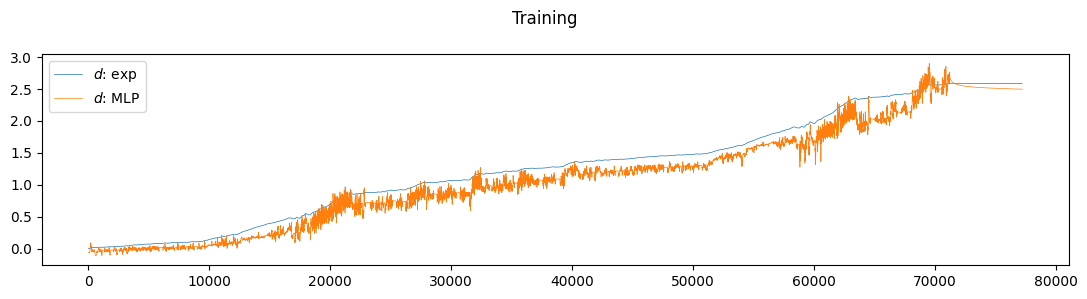

validation RMS error: 0.22895312024369693


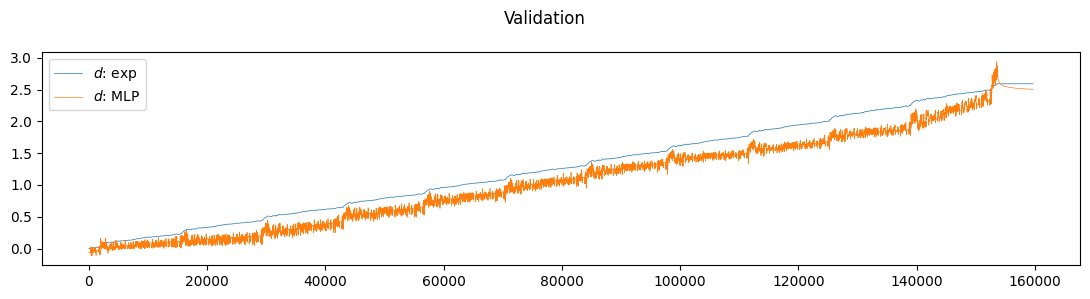

In [4]:
# Predict for training data and plot
pred_output_sequences = jax.vmap(model)(input_sequences)

print(
    "taining RMS error:",
    jnp.sqrt(jnp.mean((output_sequences - pred_output_sequences) ** 2)),
)

lw = 0.5
fig, ax = plt.subplots(figsize=(11, 3))
ax.plot(output_sequences[:, 0], label=r"$d$: exp", lw=lw)
ax.plot(pred_output_sequences[:, 0], label=r"$d$: MLP", lw=lw)
fig.suptitle("Training")
fig.tight_layout()
ax.legend()
plt.show()

# Predict for validation data and plot
input_sequences_val = jnp.vstack((vt_val, curr_val)).T
output_sequences_val = jnp.array(d_val.reshape((d_val.size, 1)))

pred_output_sequences_val = jax.vmap(model)(input_sequences_val)

print(
    "validation RMS error:",
    jnp.sqrt(jnp.mean((output_sequences_val - pred_output_sequences_val) ** 2)),
)

fig, ax = plt.subplots(figsize=(11, 3))
ax.plot(output_sequences_val[:, 0], label=r"$d$: exp", lw=lw)
ax.plot(pred_output_sequences_val[:, 0], label=r"$d$: MLP", lw=lw)
fig.suptitle("Validation")
fig.tight_layout()
ax.legend()
plt.show()

## Filtered features
We can train the network longer with a smaller learning rate to improve performance. However, we note that the MLP predictions are rather noisy. This phenomenon has been reported in the [literature](https://doi.org/10.1016/j.est.2021.103660), and it has been suggested to use filtered waveforms for the input current and voltages. In particular, it has been suggested that two first-order Butterworth filters with cutoff frequencies 0.5 mHz and 5 mHz be utilised. Let's try this approach

In [5]:
from scipy.signal import butter, filtfilt


def butterworth_filter(time_series, cutoff_freq, sampling_rate, order=1):
    """
    Apply a Butterworth filter to a time-series data.

    Parameters:
    time_series (array-like): The input time-series data.
    cutoff_freq (float): The cutoff frequency of the filter in Hz.
    sampling_rate (float): The sampling rate of the time-series data in Hz.
    order (int): The order of the filter. Default is 1.

    Returns:
    array-like: Filtered time-series data.
    """
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    filtered_data = filtfilt(b, a, time_series)
    return filtered_data


Ts = 0.1  # We resampled the original dataset with this timestep.
fc1 = 5e-04  # 0.5 mHz cutoff frequency
fc2 = 5e-03  # 5 mHz cutoff frequency

vt_f1_train = butterworth_filter(vt_train, fc1, 1.0 / Ts, order=1)
vt_f2_train = butterworth_filter(vt_train, fc2, 1.0 / Ts, order=1)

curr_f1_train = butterworth_filter(curr_train, fc1, 1.0 / Ts, order=1)
curr_f2_train = butterworth_filter(curr_train, fc2, 1.0 / Ts, order=1)

and retrain the MLP with the new features (since the input size has increased, we also increase the hidden layer sizes; the MLP architecture can be experimented with)

In [6]:
mlp_config = {
    "key": key,
    "in_size": 4,  # [vt_f1[k], vt_f2[k], curr_f1, curr_f2]
    "out_size": 1,  # [d[k]]
    "width_size": 256,
    "depth": 2,
    "activation": jax.nn.relu,
}

model = eqx.nn.MLP(**mlp_config)
# print(model)

In [7]:
# Training data
input_sequences = jnp.vstack((vt_f1_train, vt_f2_train, curr_f1_train, curr_f2_train)).T
output_sequences = jnp.array(d_train.reshape((d_train.size, 1)))

# Optax optimizer
optimizer = optax.adam(learning_rate=0.01)

# Initialize optimizer state
params = eqx.filter(model, eqx.is_array)
opt_state = optimizer.init(params)

# Gradient descent loop
num_epochs = 1000
for epoch in range(num_epochs):
    loss, gradients = value_and_grads(model, input_sequences, output_sequences)
    updates, opt_state = optimizer.update(gradients, opt_state, model)
    model = eqx.apply_updates(model, updates)

    # Print the function value at the current parameters
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.6f}")

Epoch [50/1000], Loss: 0.688546
Epoch [100/1000], Loss: 0.061225
Epoch [150/1000], Loss: 0.010546
Epoch [200/1000], Loss: 0.006317
Epoch [250/1000], Loss: 0.006506
Epoch [300/1000], Loss: 0.004786
Epoch [350/1000], Loss: 0.003585
Epoch [400/1000], Loss: 0.112219
Epoch [450/1000], Loss: 0.009925
Epoch [500/1000], Loss: 0.002947
Epoch [550/1000], Loss: 0.002749
Epoch [600/1000], Loss: 0.002645
Epoch [650/1000], Loss: 0.002629
Epoch [700/1000], Loss: 0.004356
Epoch [750/1000], Loss: 0.002618
Epoch [800/1000], Loss: 0.002424
Epoch [850/1000], Loss: 0.002320
Epoch [900/1000], Loss: 0.002231
Epoch [950/1000], Loss: 0.012170
Epoch [1000/1000], Loss: 0.001794


taining RMS error: 0.04162581857538986


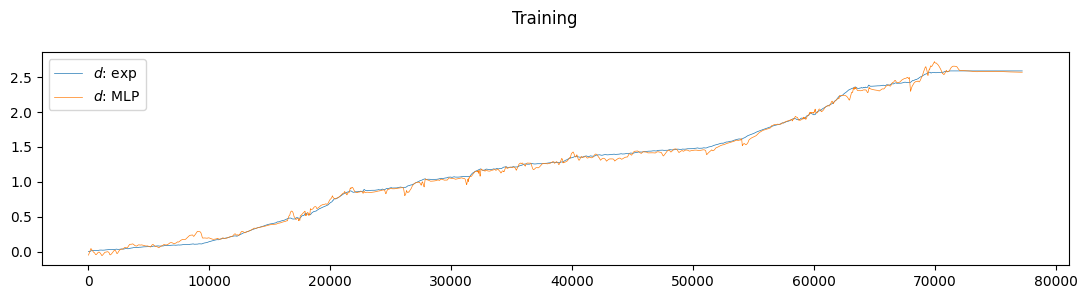

validation RMS error: 0.11089353197166589


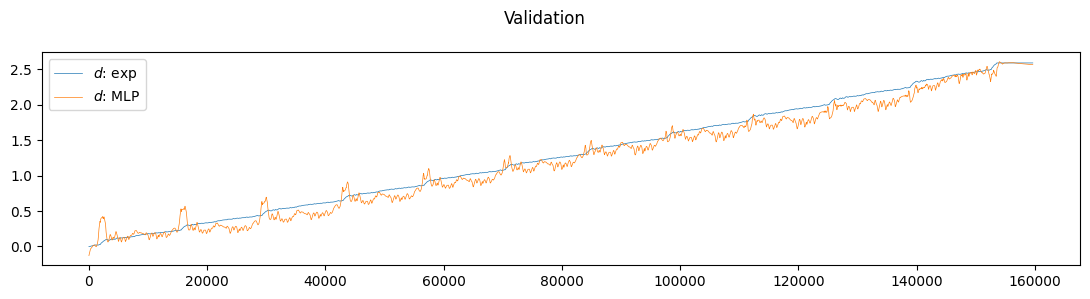

In [8]:
# Predict for training data and plot
pred_output_sequences = jax.vmap(model)(input_sequences)

print(
    "taining RMS error:",
    jnp.sqrt(jnp.mean((output_sequences - pred_output_sequences) ** 2)),
)

lw = 0.5
fig, ax = plt.subplots(figsize=(11, 3))
ax.plot(output_sequences[:, 0], label=r"$d$: exp", lw=lw)
ax.plot(pred_output_sequences[:, 0], label=r"$d$: MLP", lw=lw)
fig.suptitle("Training")
fig.tight_layout()
ax.legend()
plt.show()

# Predict for validation data and plot
vt_f1_val = butterworth_filter(vt_val, fc1, 1.0 / Ts, order=1)
vt_f2_val = butterworth_filter(vt_val, fc2, 1.0 / Ts, order=1)

curr_f1_val = butterworth_filter(curr_val, fc1, 1.0 / Ts, order=1)
curr_f2_val = butterworth_filter(curr_val, fc2, 1.0 / Ts, order=1)

input_sequences_val = jnp.vstack((vt_f1_val, vt_f2_val, curr_f1_val, curr_f2_val)).T
output_sequences_val = jnp.array(d_val.reshape((d_val.size, 1)))

pred_output_sequences_val = jax.vmap(model)(input_sequences_val)

print(
    "validation RMS error:",
    jnp.sqrt(jnp.mean((output_sequences_val - pred_output_sequences_val) ** 2)),
)

fig, ax = plt.subplots(figsize=(11, 3))
ax.plot(output_sequences_val[:, 0], label=r"$d$: exp", lw=lw)
ax.plot(pred_output_sequences_val[:, 0], label=r"$d$: MLP", lw=lw)
fig.suptitle("Validation")
fig.tight_layout()
ax.legend()
plt.show()

The model is comparatively smoother predictions. Model accuracy and removal of the apparent bias in the validation data may be achieved by tuning the MLP architecture and/or considering other NN architectures. 

## Including the MLP in Collimator

To included the extended MLP model in Collimator, we can leverage the available `MLP` block in the Collimator library and transfer the parameters of our trained equinox model to the Collimator MLP block. For the inputs to the MLP, we can reuse the `DiscreteSource` system that we created earlier for the four inputs to the MLP and combine them with a `Multiplexer` block.

Note: we work with the filtered signals in the Collimator implementation here. However, one could work with the raw signals and filter them within the Collimator model by specifying the transfer-function of the filters and using the `TransferFunction` block available in the Collimator library.

In [9]:
import collimator
from collimator.framework import LeafSystem
from collimator.library import Constant, MLP, Multiplexer

from collimator.simulation import SimulatorOptions, ODESolverOptions

from typing import NamedTuple


class DiscreteSource(LeafSystem):
    class DiscreteStateType(NamedTuple):
        index: jnp.int64
        source_val: jnp.float64

    def __init__(self, val_array, dt, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.val_array = val_array
        self.dt = dt

        self.declare_discrete_state(
            default_value=self.DiscreteStateType(index=0, source_val=val_array[0]),
            as_array=False,
        )

        self.declare_periodic_update(
            self._update,
            period=self.dt,
            offset=0,
        )

        self.declare_output_port(
            self._compute_output,
            default_value=self.val_array[0],
            period=self.dt,
            offset=0.0,
            requires_inputs = False,
        )

    def _compute_output(self, time, state, **params):
        return state.discrete_state.source_val

    def _update(self, time, state, *inputs, **params):
        index = state.discrete_state.index
        index = index + 1
        source_val = self.val_array[index]
        return self.DiscreteStateType(index=index, source_val=source_val)

In [10]:
builder = collimator.DiagramBuilder()

dt = 0.1

## Creating a new dictionary with updated key names to align with Collimator API
wc_mlp_config = mlp_config.copy()  # Copy the original equinox config
wc_mlp_config["input_size"] = wc_mlp_config.pop(
    "in_size"
)  # Rename 'in_size' to 'input_size'
wc_mlp_config["output_size"] = wc_mlp_config.pop(
    "out_size"
)  # Rename 'out_size' to 'output_size'
wc_mlp_config["activation_str"] = wc_mlp_config.pop(
    "activation"
)  # Rename 'activation' to 'activation_str'
wc_mlp_config["activation_str"] = "relu"  # Set activation string

# Create the MLP block in Collimator
mlp = builder.add(MLP(**wc_mlp_config, name="mlp"))

# Add the input blocks as Discrete sources
vt_f1 = builder.add(DiscreteSource(jnp.array(vt_f1_train), dt=dt, name="vt_f1"))
vt_f2 = builder.add(DiscreteSource(jnp.array(vt_f2_train), dt=dt, name="vt_f2"))

curr_f1 = builder.add(DiscreteSource(jnp.array(curr_f1_train), dt=dt, name="curr_f1"))
curr_f2 = builder.add(DiscreteSource(jnp.array(curr_f2_train), dt=dt, name="curr_f2"))

# Add the multiplexer block to combine all the inputs prior to feeding the MLP
mux = builder.add(Multiplexer(4, name="mux"))

# Wire up the diagram
builder.connect(vt_f1.output_ports[0], mux.input_ports[0])
builder.connect(vt_f2.output_ports[0], mux.input_ports[1])
builder.connect(curr_f1.output_ports[0], mux.input_ports[2])
builder.connect(curr_f2.output_ports[0], mux.input_ports[3])

builder.connect(mux.output_ports[0], mlp.input_ports[0])

## build diagram and context
diagram = builder.build()
context = diagram.create_context()

# Update the mlp in the context to the trained parameters (transfer equinox model parameters to the Collimator MLP)
eqx_model = model
eqx_mlp_params, eqx_static = eqx.partition(
    eqx_model, eqx.is_array
)  # Get equinox parameters
subcontext = context[diagram["mlp"].system_id].with_parameter(
    "nn_params", eqx_mlp_params
)  # set Collimator mlp parameters
context = context.with_subcontext(diagram["mlp"].system_id, subcontext)

recorded_signals = {"d": diagram["mlp"].output_ports[0]}

options = SimulatorOptions(max_major_steps=ceil(t_train[-1] / dt))
sol = collimator.simulate(
    diagram,
    context,
    (0.0, t_train[-1]),
    options=options,
    recorded_signals=recorded_signals,
)

collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=77225, ode_solver_method=default, rtol=0.001, atol=1e-06, min_minor_step_size=None, max_minor_step_size=None, max_minor_steps_per_major_step=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=1, return_context=True), DiffraxSolver(system=Diagram(root, 6 nodes), rtol=0.001, atol=1e-06, max_steps=4096, max_step_size=None, min_step_size=None, method='default', save_steps=True, return_step_interpolant=False)


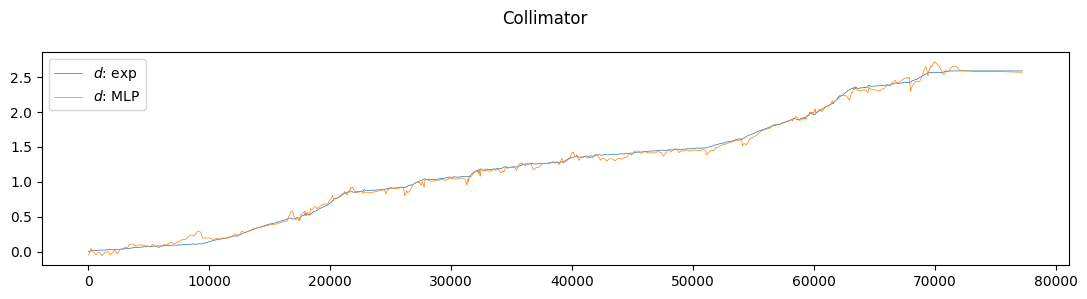

In [11]:
fig, ax = plt.subplots(figsize=(11, 3))
ax.plot(output_sequences[:, 0], label=r"$d$: exp", lw=lw)
ax.plot(sol.outputs["d"][:, 0], label=r"$d$: MLP", lw=lw)
fig.suptitle("Collimator")
fig.tight_layout()
ax.legend()
plt.show()